In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the dataset
file_path = '/content/easy.csv'  # Replace with the path to your dataset
dataset = pd.read_csv(file_path)

# Convert 'Date_Time' to datetime and extract useful features
dataset['Date_Time'] = pd.to_datetime(dataset['Date_Time'])
dataset['Hour'] = dataset['Date_Time'].dt.hour
dataset['Day'] = dataset['Date_Time'].dt.day
dataset['Month'] = dataset['Date_Time'].dt.month

# Add user-specific baselines
dataset['User_Avg_Amount'] = dataset.groupby('User_ID')['Amount'].transform('mean')
dataset['User_Avg_Frequency'] = dataset.groupby('User_ID')['Transaction_Frequency'].transform('mean')
dataset['Amount_Deviation'] = dataset['Amount'] / dataset['User_Avg_Amount']
dataset['Frequency_Deviation'] = dataset['Transaction_Frequency'] / dataset['User_Avg_Frequency']

# Typical transaction time for each user
dataset['User_Avg_Hour'] = dataset.groupby('User_ID')['Hour'].transform('mean')
dataset['Hour_Deviation'] = abs(dataset['Hour'] - dataset['User_Avg_Hour'])

# Add enhanced behavioral analytics if 'Behavioral_Score' exists
if 'Behavioral_Score' in dataset.columns:
    dataset['Unusual_Activities'] = dataset['Behavioral_Score'] > dataset['Behavioral_Score'].quantile(0.9)
else:
    print("Column 'Behavioral_Score' not found in dataset.")
    dataset['Unusual_Activities'] = False  # Add a default column for compatibility

# Drop unnecessary columns
columns_to_drop = ['User_ID', 'Transaction_ID', 'Date_Time', 'IP_Address', 'Location_City']
dataset = dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns])

# Define the target variable
target = 'Suspicious'

# Pre-Fraud Features
pre_fraud_features = ['Latitude', 'Longitude', 'Amount', 'Transaction_Frequency',
                      'Merchant_Category', 'Payment_Method', 'Device', 'Risk_Profile',
                      'Hour', 'Day', 'Month', 'Amount_Deviation', 'Frequency_Deviation', 'Hour_Deviation']

# Post-Fraud Features (Includes Pre-Fraud + additional behavioral features)
post_fraud_features = pre_fraud_features + ['Behavioral_Score', 'Unusual_Activities'] if 'Behavioral_Score' in dataset else pre_fraud_features

# Split dataset for pre-fraud and post-fraud modeling
pre_fraud_data = dataset[pre_fraud_features + [target]]
post_fraud_data = dataset[post_fraud_features + [target]]

# Pre-Fraud: Prepare data
X_pre = pre_fraud_data.drop(target, axis=1)
y_pre = pre_fraud_data[target]
X_pre_train, X_pre_test, y_pre_train, y_pre_test = train_test_split(X_pre, y_pre, test_size=0.3, random_state=42)

# Post-Fraud: Prepare data
X_post = post_fraud_data.drop(target, axis=1)
y_post = post_fraud_data[target]
X_post_train, X_post_test, y_post_train, y_post_test = train_test_split(X_post, y_post, test_size=0.3, random_state=42)

# Define preprocessing pipelines
numeric_features_pre = ['Latitude', 'Longitude', 'Amount', 'Transaction_Frequency', 'Hour', 'Day', 'Month',
                        'Amount_Deviation', 'Frequency_Deviation', 'Hour_Deviation']
categorical_features_pre = ['Merchant_Category', 'Payment_Method', 'Device', 'Risk_Profile']

numeric_features_post = numeric_features_pre + ['Behavioral_Score'] if 'Behavioral_Score' in dataset else numeric_features_pre
categorical_features_post = categorical_features_pre + ['Unusual_Activities'] if 'Behavioral_Score' in dataset else categorical_features_pre

preprocessor_pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_pre),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_pre)
    ]
)

preprocessor_post = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_post),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_post)
    ]
)

# Define pipelines for pre- and post-fraud
pipeline_pre = Pipeline(steps=[
    ('preprocessor', preprocessor_pre),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline_post = Pipeline(steps=[
    ('preprocessor', preprocessor_post),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Train and evaluate the pre-fraud model
pipeline_pre.fit(X_pre_train, y_pre_train)
y_pre_pred = pipeline_pre.predict(X_pre_test)
print("Pre-Fraud Detection Classification Report:")
print(classification_report(y_pre_test, y_pre_pred))

# Train and evaluate the post-fraud model
pipeline_post.fit(X_post_train, y_post_train)
y_post_pred = pipeline_post.predict(X_post_test)
print("Post-Fraud Detection Classification Report:")
print(classification_report(y_post_test, y_post_pred))

Column 'Behavioral_Score' not found in dataset.
Pre-Fraud Detection Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2859
           1       0.00      0.00      0.00       141

    accuracy                           0.95      3000
   macro avg       0.48      0.50      0.49      3000
weighted avg       0.91      0.95      0.93      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Post-Fraud Detection Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2859
           1       0.00      0.00      0.00       141

    accuracy                           0.95      3000
   macro avg       0.48      0.50      0.49      3000
weighted avg       0.91      0.95      0.93      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# Load the dataset
file_path = '/content/easy.csv'  # Replace with your dataset path
dataset = pd.read_csv(file_path)

# Convert 'Date_Time' to datetime and extract useful features
dataset['Date_Time'] = pd.to_datetime(dataset['Date_Time'])
dataset['Hour'] = dataset['Date_Time'].dt.hour
dataset['Day'] = dataset['Date_Time'].dt.day
dataset['Month'] = dataset['Date_Time'].dt.month

# Add user-specific baselines
dataset['User_Avg_Amount'] = dataset.groupby('User_ID')['Amount'].transform('mean')
dataset['User_Avg_Frequency'] = dataset.groupby('User_ID')['Transaction_Frequency'].transform('mean')
dataset['Amount_Deviation'] = dataset['Amount'] / dataset['User_Avg_Amount']
dataset['Frequency_Deviation'] = dataset['Transaction_Frequency'] / dataset['User_Avg_Frequency']
dataset['User_Avg_Hour'] = dataset.groupby('User_ID')['Hour'].transform('mean')
dataset['Hour_Deviation'] = abs(dataset['Hour'] - dataset['User_Avg_Hour'])

# Drop unnecessary columns
columns_to_drop = ['User_ID', 'Transaction_ID', 'Date_Time', 'IP_Address', 'Location_City']
dataset = dataset.drop(columns=columns_to_drop)

# Define target variable
target = 'Suspicious'

# Pre-Fraud and Post-Fraud Features
pre_fraud_features = ['Latitude', 'Longitude', 'Amount', 'Transaction_Frequency', 'Merchant_Category',
                      'Payment_Method', 'Device', 'Risk_Profile', 'Hour', 'Day', 'Month', 'Amount_Deviation',
                      'Frequency_Deviation', 'Hour_Deviation']
post_fraud_features = pre_fraud_features + ['Location_Match', 'Behavioral_Score', 'Unusual_Activities']

# Check for 'Behavioral_Score' and 'Unusual_Activities' columns and add them if they don't exist
# This ensures that the features used later are present in the dataset
if 'Behavioral_Score' not in dataset.columns:
    dataset['Behavioral_Score'] = 0  # Placeholder
if 'Unusual_Activities' not in dataset.columns:
    dataset['Unusual_Activities'] = 0 # Placeholder or False based on your logic


# Prepare unified feature set
features = list(set(pre_fraud_features + post_fraud_features))
X = dataset[features]
y = dataset[target]

# Handle categorical and numerical features
categorical_features = ['Merchant_Category', 'Payment_Method', 'Device', 'Risk_Profile']
numeric_features = list(set(features) - set(categorical_features))

# ... (rest of your code remains the same)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dimensionality Reduction for Behavioral Embeddings
pca = PCA(n_components=5)
X_train_embeddings = pca.fit_transform(X_train[numeric_features])
X_test_embeddings = pca.transform(X_test[numeric_features])

# Anomaly Detection
iso_forest = IsolationForest(random_state=42, contamination=0.1)
X_train['Anomaly_Score'] = iso_forest.fit_predict(X_train_embeddings)
X_test['Anomaly_Score'] = iso_forest.predict(X_test_embeddings)

# Normalize Anomaly Scores
X_train['Anomaly_Score'] = (X_train['Anomaly_Score'] - X_train['Anomaly_Score'].min()) / (X_train['Anomaly_Score'].max() - X_train['Anomaly_Score'].min())
X_test['Anomaly_Score'] = (X_test['Anomaly_Score'] - X_test['Anomaly_Score'].min()) / (X_test['Anomaly_Score'].max() - X_test['Anomaly_Score'].min())

# Neural Network for Hybrid Model
# Change the input shape to match the preprocessed data
input_layer = Input(shape=(X_train_preprocessed.shape[1],))  # Use preprocessed shape
shared_layer = Dense(128, activation='relu')(input_layer)
shared_layer = Dropout(0.3)(shared_layer)

# ... (rest of your code remains the same)

# Pre-Fraud Output
pre_fraud_layer = Dense(64, activation='relu')(shared_layer)
pre_fraud_output = Dense(1, activation='sigmoid', name='pre_fraud')(pre_fraud_layer)

# Post-Fraud Output
post_fraud_layer = Dense(64, activation='relu')(shared_layer)
post_fraud_output = Dense(1, activation='sigmoid', name='post_fraud')(post_fraud_layer)

# Combine into Multi-Task Model
model = Model(inputs=input_layer, outputs=[pre_fraud_output, post_fraud_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[['accuracy'], ['accuracy']]) # Provide a list of metrics for each output
# Preprocess Data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train the Model
history = model.fit(X_train_preprocessed, [y_train, y_train], epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the Model
results = model.evaluate(X_test_preprocessed, [y_test, y_test])
print("Evaluation Results:", results)

# Predictions
y_pre_pred, y_post_pred = model.predict(X_test_preprocessed)
print("Pre-Fraud Classification Report:")
print(classification_report(y_test, (y_pre_pred > 0.5).astype(int)))
print("Post-Fraud Classification Report:")
print(classification_report(y_test, (y_post_pred > 0.5).astype(int)))


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5268 - post_fraud_accuracy: 0.8719 - post_fraud_loss: 0.2928 - pre_fraud_accuracy: 0.9313 - pre_fraud_loss: 0.2340 - val_loss: 0.2123 - val_post_fraud_accuracy: 0.9486 - val_post_fraud_loss: 0.1056 - val_pre_fraud_accuracy: 0.9457 - val_pre_fraud_loss: 0.1064
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1984 - post_fraud_accuracy: 0.9487 - post_fraud_loss: 0.1005 - pre_fraud_accuracy: 0.9511 - pre_fraud_loss: 0.0979 - val_loss: 0.2093 - val_post_fraud_accuracy: 0.9486 - val_post_fraud_loss: 0.1042 - val_pre_fraud_accuracy: 0.9500 - val_pre_fraud_loss: 0.1048
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1902 - post_fraud_accuracy: 0.9491 - post_fraud_loss: 0.0954 - pre_fraud_accuracy: 0.9518 - pre_fraud_loss: 0.0948 - val_loss: 0.2068 - val_post_fraud_accuracy: 0.9500 - val_post_fraud_loss: 0.1030 - val_pre_fraud_accuracy: 0.9493 - val_pre_fraud_loss: 0.1036
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Pre-Fraud Evaluation
pre_fraud_metrics = {
    'Accuracy': accuracy_score(y_test, (y_pre_pred > 0.5).astype(int)),
    'Precision': precision_score(y_test, (y_pre_pred > 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_pre_pred > 0.5).astype(int)),
    'F1-Score': f1_score(y_test, (y_pre_pred > 0.5).astype(int)),
    'ROC-AUC': roc_auc_score(y_test, y_pre_pred)
}

# Post-Fraud Evaluation
post_fraud_metrics = {
    'Accuracy': accuracy_score(y_test, (y_post_pred > 0.5).astype(int)),
    'Precision': precision_score(y_test, (y_post_pred > 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_post_pred > 0.5).astype(int)),
    'F1-Score': f1_score(y_test, (y_post_pred > 0.5).astype(int)),
    'ROC-AUC': roc_auc_score(y_test, y_post_pred)
}

print("Pre-Fraud Metrics:", pre_fraud_metrics)
print("Post-Fraud Metrics:", post_fraud_metrics)

# Full Classification Report
print("Pre-Fraud Classification Report:")
print(classification_report(y_test, (y_pre_pred > 0.5).astype(int)))

print("Post-Fraud Classification Report:")
print(classification_report(y_test, (y_post_pred > 0.5).astype(int)))


Pre-Fraud Metrics: {'Accuracy': 0.9466666666666667, 'Precision': 0.2978723404255319, 'Recall': 0.09929078014184398, 'F1-Score': 0.14893617021276595, 'ROC-AUC': 0.9537903199799562}
Post-Fraud Metrics: {'Accuracy': 0.947, 'Precision': 0.3269230769230769, 'Recall': 0.12056737588652482, 'F1-Score': 0.17616580310880828, 'ROC-AUC': 0.9535869060996877}
Pre-Fraud Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2859
           1       0.30      0.10      0.15       141

    accuracy                           0.95      3000
   macro avg       0.63      0.54      0.56      3000
weighted avg       0.93      0.95      0.93      3000

Post-Fraud Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2859
           1       0.33      0.12      0.18       141

    accuracy                           0.95      3000
   macro avg       0.64      0.55      0

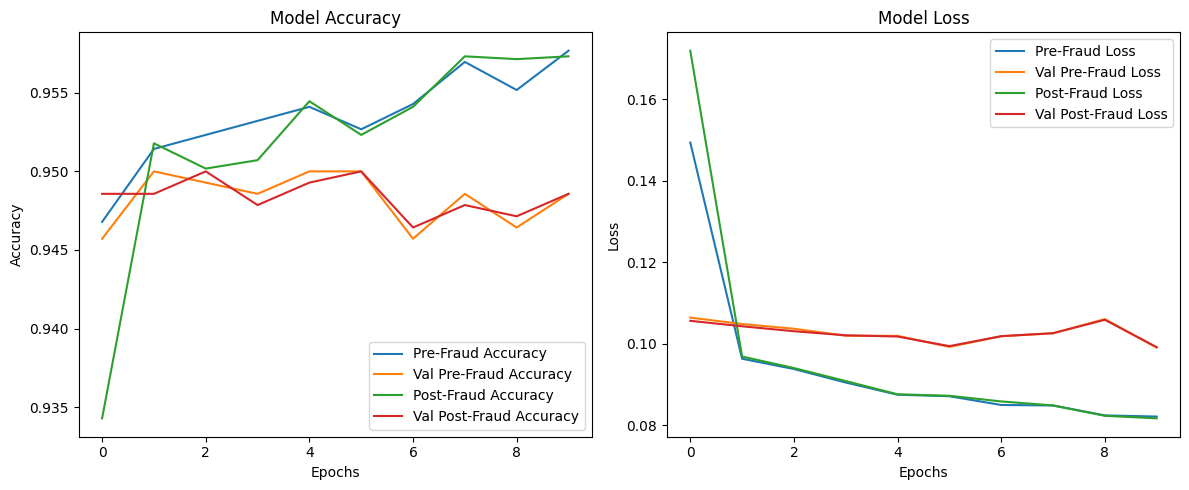

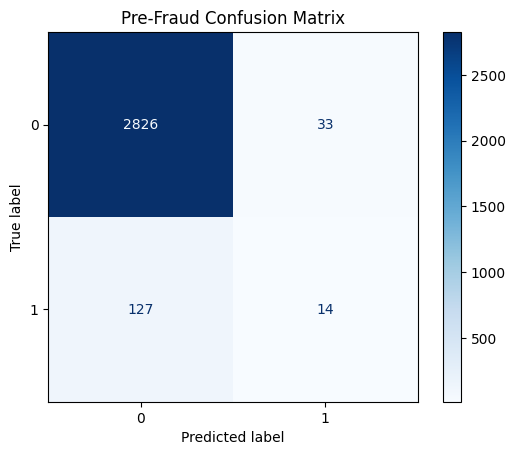

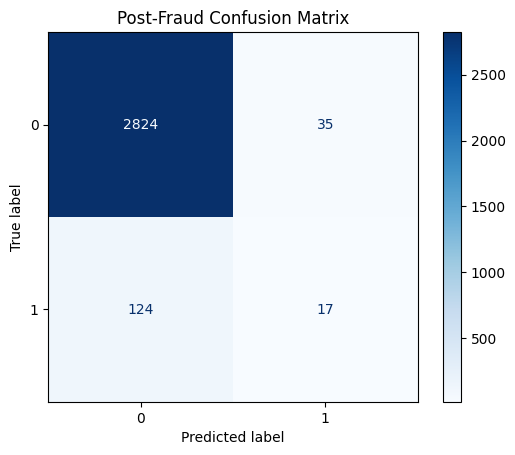

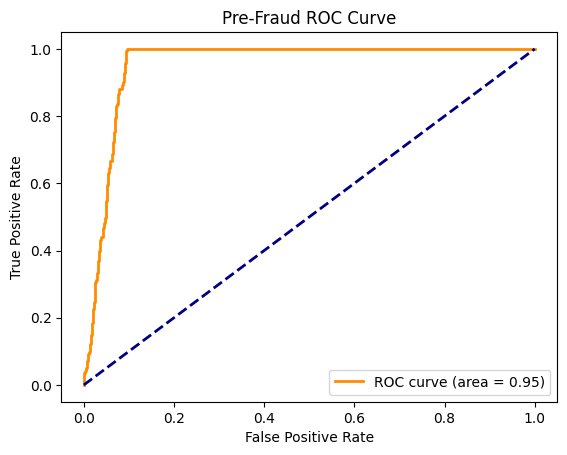

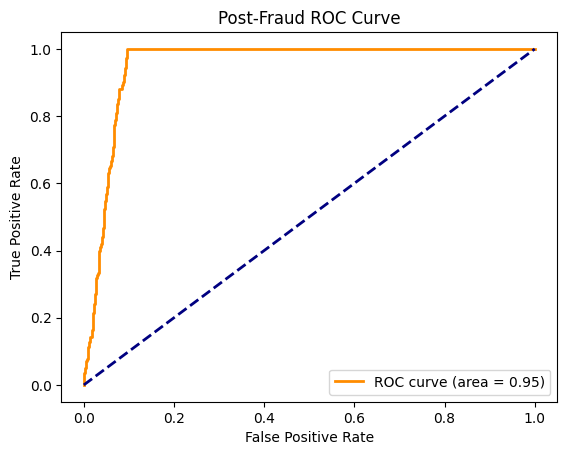

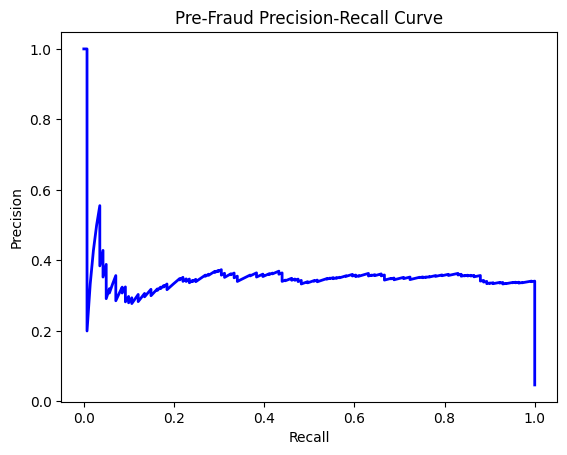

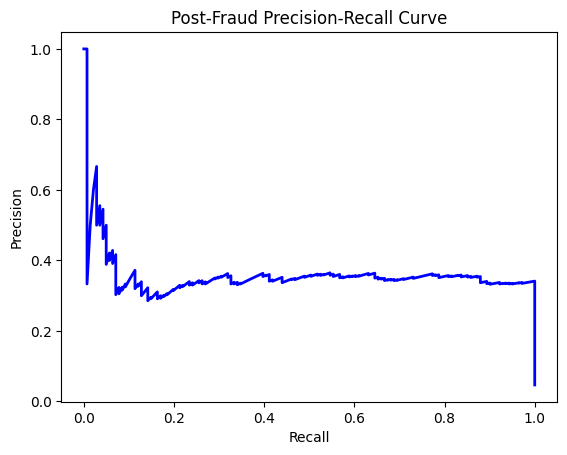

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

# Function to plot model training history
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['pre_fraud_accuracy'], label='Pre-Fraud Accuracy')
    plt.plot(history.history['val_pre_fraud_accuracy'], label='Val Pre-Fraud Accuracy')
    plt.plot(history.history['post_fraud_accuracy'], label='Post-Fraud Accuracy')
    plt.plot(history.history['val_post_fraud_accuracy'], label='Val Post-Fraud Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['pre_fraud_loss'], label='Pre-Fraud Loss')
    plt.plot(history.history['val_pre_fraud_loss'], label='Val Pre-Fraud Loss')
    plt.plot(history.history['post_fraud_loss'], label='Post-Fraud Loss')
    plt.plot(history.history['val_post_fraud_loss'], label='Val Post-Fraud Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

# Pre-Fraud Confusion Matrix
plot_confusion_matrix(y_test, y_pre_pred, "Pre-Fraud Confusion Matrix")

# Post-Fraud Confusion Matrix
plot_confusion_matrix(y_test, y_post_pred, "Post-Fraud Confusion Matrix")

# ROC Curve
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Pre-Fraud ROC Curve
plot_roc_curve(y_test, y_pre_pred, "Pre-Fraud ROC Curve")

# Post-Fraud ROC Curve
plot_roc_curve(y_test, y_post_pred, "Post-Fraud ROC Curve")

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Pre-Fraud Precision-Recall Curve
plot_precision_recall_curve(y_test, y_pre_pred, "Pre-Fraud Precision-Recall Curve")

# Post-Fraud Precision-Recall Curve
plot_precision_recall_curve(y_test, y_post_pred, "Post-Fraud Precision-Recall Curve")


In [ ]:
# Sample new user data (replace with actual new data)
new_user_data = pd.DataFrame({
    'Latitude': [13.0827],
    'Longitude': [80.2707],
    'Amount': [50000],
    'Transaction_Frequency': [2],
    'Merchant_Category': ['Electronics'],
    'Payment_Method': ['Credit_Card'],
    'Device': ['UPI'],
    'Risk_Profile': ['Medium'],
    'Hour': [24],
    'Day': [16],
    'Month': [12],
    'Amount_Deviation': [1.2],  # Derived features must match training data logic
    'Frequency_Deviation': [0.8],
    'Hour_Deviation': [4],
    'Location_Match': [2],  # Post-fraud-specific feature
    'Behavioral_Score': [0.5],  # Placeholder or calculated feature
    'Unusual_Activities': [1]  # Placeholder or calculated feature
})

# Preprocess new data
new_user_data_preprocessed = preprocessor.transform(new_user_data)

# Run predictions
pre_fraud_pred, post_fraud_pred = model.predict(new_user_data_preprocessed)

# Threshold predictions (adjust threshold if needed)
pre_fraud_result = (pre_fraud_pred > 0.5).astype(int)
post_fraud_result = (post_fraud_pred > 0.5).astype(int)

# Output results
print("Pre-Fraud Prediction (Probability):", pre_fraud_pred[0][0])
print("Pre-Fraud Result (Class):", "Fraud" if pre_fraud_result[0][0] == 1 else "Not Fraud")

print("Post-Fraud Prediction (Probability):", post_fraud_pred[0][0])
print("Post-Fraud Result (Class):", "Fraud" if post_fraud_result[0][0] == 1 else "Not Fraud")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Pre-Fraud Prediction (Probability): 7.6230785e-32
Pre-Fraud Result (Class): Not Fraud
Post-Fraud Prediction (Probability): 2.5806848e-31
Post-Fraud Result (Class): Not Fraud


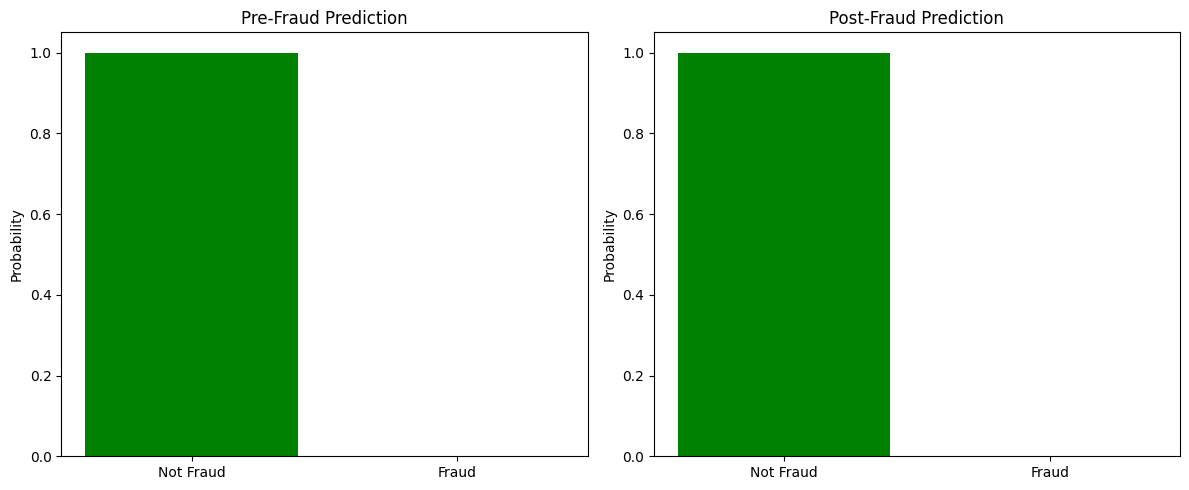

In [ ]:
# Visualization of Prediction Probabilities
labels = ['Not Fraud', 'Fraud']
pre_fraud_probs = [1 - pre_fraud_pred[0][0], pre_fraud_pred[0][0]]
post_fraud_probs = [1 - post_fraud_pred[0][0], post_fraud_pred[0][0]]

plt.figure(figsize=(12, 5))

# Pre-Fraud Prediction
plt.subplot(1, 2, 1)
plt.bar(labels, pre_fraud_probs, color=['green', 'red'])
plt.title('Pre-Fraud Prediction')
plt.ylabel('Probability')

# Post-Fraud Prediction
plt.subplot(1, 2, 2)
plt.bar(labels, post_fraud_probs, color=['green', 'red'])
plt.title('Post-Fraud Prediction')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
import shap  # For explainable AI

# Load the dataset
file_path = '/content/easy.csv'  # Replace with your dataset path
dataset = pd.read_csv(file_path)

# Convert 'Date_Time' to datetime and extract useful features
dataset['Date_Time'] = pd.to_datetime(dataset['Date_Time'])
dataset['Hour'] = dataset['Date_Time'].dt.hour
dataset['Day'] = dataset['Date_Time'].dt.day
dataset['Month'] = dataset['Date_Time'].dt.month

# Add user-specific baselines
dataset['User_Avg_Amount'] = dataset.groupby('User_ID')['Amount'].transform('mean')
dataset['User_Avg_Frequency'] = dataset.groupby('User_ID')['Transaction_Frequency'].transform('mean')
dataset['Amount_Deviation'] = dataset['Amount'] / dataset['User_Avg_Amount']
dataset['Frequency_Deviation'] = dataset['Transaction_Frequency'] / dataset['User_Avg_Frequency']
dataset['User_Avg_Hour'] = dataset.groupby('User_ID')['Hour'].transform('mean')
dataset['Hour_Deviation'] = abs(dataset['Hour'] - dataset['User_Avg_Hour'])

# Drop unnecessary columns
columns_to_drop = ['User_ID', 'Transaction_ID', 'Date_Time', 'IP_Address', 'Location_City']
dataset = dataset.drop(columns=columns_to_drop)

# Define target variable
target = 'Suspicious'

# Pre-Fraud and Post-Fraud Features
pre_fraud_features = ['Latitude', 'Longitude', 'Amount', 'Transaction_Frequency', 'Merchant_Category',
                      'Payment_Method', 'Device', 'Risk_Profile', 'Hour', 'Day', 'Month', 'Amount_Deviation',
                      'Frequency_Deviation', 'Hour_Deviation']
post_fraud_features = pre_fraud_features + ['Location_Match', 'Behavioral_Score', 'Unusual_Activities']

# Add missing columns for placeholder features
if 'Behavioral_Score' not in dataset.columns:
    dataset['Behavioral_Score'] = 0  # Placeholder
if 'Unusual_Activities' not in dataset.columns:
    dataset['Unusual_Activities'] = 0  # Placeholder

# Prepare unified feature set
features = list(set(pre_fraud_features + post_fraud_features))
X = dataset[features]
y = dataset[target]

# Handle categorical and numerical features
categorical_features = ['Merchant_Category', 'Payment_Method', 'Device', 'Risk_Profile']
numeric_features = list(set(features) - set(categorical_features))

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dimensionality Reduction for Behavioral Embeddings
pca = PCA(n_components=5)
X_train_embeddings = pca.fit_transform(X_train[numeric_features])
X_test_embeddings = pca.transform(X_test[numeric_features])

# Anomaly Detection
iso_forest = IsolationForest(random_state=42, contamination=0.1)
X_train['Anomaly_Score'] = iso_forest.fit_predict(X_train_embeddings)
X_test['Anomaly_Score'] = iso_forest.predict(X_test_embeddings)

# Normalize Anomaly Scores
X_train['Anomaly_Score'] = (X_train['Anomaly_Score'] - X_train['Anomaly_Score'].min()) / (X_train['Anomaly_Score'].max() - X_train['Anomaly_Score'].min())
X_test['Anomaly_Score'] = (X_test['Anomaly_Score'] - X_test['Anomaly_Score'].min()) / (X_test['Anomaly_Score'].max() - X_test['Anomaly_Score'].min())

# Neural Network for Hybrid Model
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

input_layer = Input(shape=(X_train_preprocessed.shape[1],))  # Use preprocessed shape
shared_layer = Dense(128, activation='relu')(input_layer)
shared_layer = Dropout(0.3)(shared_layer)

# Pre-Fraud Output
pre_fraud_layer = Dense(64, activation='relu')(shared_layer)
pre_fraud_output = Dense(1, activation='sigmoid', name='pre_fraud')(pre_fraud_layer)

# Post-Fraud Output
post_fraud_layer = Dense(64, activation='relu')(shared_layer)
post_fraud_output = Dense(1, activation='sigmoid', name='post_fraud')(post_fraud_layer)

# Combine into Multi-Task Model
model = Model(inputs=input_layer, outputs=[pre_fraud_output, post_fraud_output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[['accuracy'], ['accuracy']])

# Train the Model
history = model.fit(X_train_preprocessed, [y_train, y_train], epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the Model
results = model.evaluate(X_test_preprocessed, [y_test, y_test])
print("Evaluation Results:", results)

# Predictions
y_pre_pred, y_post_pred = model.predict(X_test_preprocessed)
print("Pre-Fraud Classification Report:")
print(classification_report(y_test, (y_pre_pred > 0.5).astype(int)))
print("Post-Fraud Classification Report:")
print(classification_report(y_test, (y_post_pred > 0.5).astype(int)))




Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4196 - post_fraud_accuracy: 0.9330 - post_fraud_loss: 0.2237 - pre_fraud_accuracy: 0.9462 - pre_fraud_loss: 0.1959 - val_loss: 0.2163 - val_post_fraud_accuracy: 0.9471 - val_post_fraud_loss: 0.1083 - val_pre_fraud_accuracy: 0.9443 - val_pre_fraud_loss: 0.1079
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1875 - post_fraud_accuracy: 0.9517 - post_fraud_loss: 0.0940 - pre_fraud_accuracy: 0.9534 - pre_fraud_loss: 0.0935 - val_loss: 0.2138 - val_post_fraud_accuracy: 0.9407 - val_post_fraud_loss: 0.1065 - val_pre_fraud_accuracy: 0.9450 - val_pre_fraud_loss: 0.1070
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1797 - post_fraud_accuracy: 0.9518 - post_fraud_loss: 0.0905 - pre_fraud_accuracy: 0.9525 - pre_fraud_loss: 0.0892 - val_loss: 0.2051 - val_post_fraud_accuracy: 0.9471 - val_post_fraud_loss: 0.1021 - val_pre_fraud_accuracy: 0.9529 - val_pre_fraud_loss: 0.1028
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━

In [ ]:
!pip install shap